In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, recall_score, f1_score,precision_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE

from joblib import dump, load
import mlflow
import dagshub
import pickle
import shap
from lime.lime_tabular import LimeTabularExplainer

from my_utilities import custom_loss, custom_scorer

import evidently
from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, RegressionPreset
from evidently.metrics import ColumnSummaryMetric, ColumnQuantileMetric, ColumnDriftMetric
from evidently.metrics import *

from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset
from evidently.tests import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
dagshub.init("Projet7", "alexandre", mlflow=True)

Repository initialized!

In [3]:
mlflow.set_tracking_uri("https://dagshub.com/alexandre/Projet7.mlflow")

In [4]:
mlflow.set_experiment("XGBoost")

<Experiment: artifact_location='mlflow-artifacts:/04e0537cf3f7468b8c6418159d45db8e', creation_time=1692228764226, experiment_id='0', last_update_time=1692228764226, lifecycle_stage='active', name='XGBoost', tags={}>

In [5]:
# chargement de base de données
df = pd.read_csv("../Data/Processed/fichier_xgb.csv", index_col="SK_ID_CURR")

In [6]:
df.head()

,EXT_SOURCE_3,EXT_SOURCE_2,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_Higher education,OCCUPATION_TYPE_Core staff,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_HOUR,CODE_GENDER,PAYMENT_RATE,TARGET
SK_ID_CURR,,,,,,,,,,,
100002,0.139376,0.262949,True,True,False,False,1,0.000000,0,0.060749,1.0
100003,0.509353,0.622246,False,False,True,True,1,0.000000,1,0.027598,0.0
100004,0.729567,0.555912,True,True,False,False,0,0.000000,0,0.050000,0.0
100006,0.509353,0.650442,True,True,False,False,1,0.005809,1,0.094941,0.0
100007,0.509353,0.322738,True,True,False,True,0,0.000000,0,0.042623,0.0


In [7]:
df = df.rename(columns={"EXT_SOURCE_3":"Source_3",
                        "EXT_SOURCE_2" : "Source_2",
                        "NAME_INCOME_TYPE_Working" : "Travail",
                        "NAME_EDUCATION_TYPE_Secondary / secondary special" : "Lycée",
                        "NAME_EDUCATION_TYPE_Higher education" : "Etudes Sup",
                        "OCCUPATION_TYPE_Core staff" : "Cadre",
                        "FLAG_DOCUMENT_3" : "Indic_doc 3",
                        "AMT_REQ_CREDIT_BUREAU_HOUR" : "Nb demandes/h",
                        "CODE_GENDER" : "Sexe",
                        "PAYMENT_RATE" : "Tx pay.",
                })

In [8]:
cols_to_convert = ['Travail', 'Lycée', 'Etudes Sup', 'Cadre', 'TARGET']
for col in cols_to_convert:
    df[col] = df[col].astype(int)

In [9]:
df.dtypes

Source_3         float64
Source_2         float64
Travail            int32
Lycée              int32
Etudes Sup         int32
Cadre              int32
Indic_doc 3        int64
Nb demandes/h    float64
Sexe               int64
Tx pay.          float64
TARGET             int32
dtype: object

In [10]:
df.head()

,Source_3,Source_2,Travail,Lycée,Etudes Sup,Cadre,Indic_doc 3,Nb demandes/h,Sexe,Tx pay.,TARGET
SK_ID_CURR,,,,,,,,,,,
100002,0.139376,0.262949,1,1,0,0,1,0.000000,0,0.060749,1
100003,0.509353,0.622246,0,0,1,1,1,0.000000,1,0.027598,0
100004,0.729567,0.555912,1,1,0,0,0,0.000000,0,0.050000,0
100006,0.509353,0.650442,1,1,0,0,1,0.005809,1,0.094941,0
100007,0.509353,0.322738,1,1,0,1,0,0.000000,0,0.042623,0


In [11]:
cols_to_convert = ['Travail', 'Lycée', 'Etudes Sup', 'Cadre']
for col in cols_to_convert:
    df[col] = df[col].astype(int)

In [12]:
# Définir la fonction de perte personnalisée
def custom_loss(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fn_weight = 10.0  # poids pour les faux négatifs
    fp_weight = 10.0  # poids pour les faux positifs
    return cm[0, 1] * fp_weight + cm[1, 0] * fn_weight

In [13]:
# Faire une fonction d'évaluation personnalisée pour GridSearch
custom_scorer = make_scorer(custom_loss, greater_is_better=False)

In [14]:
# Séparer les données d'entraînement et de test
train_test_data = df.dropna(subset=["TARGET"])
X = train_test_data.drop(columns=["TARGET"])
y = train_test_data["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
# Combinez X_train et y_train en un seul dataframe
train_df = pd.concat([X_train, y_train], axis=1)
train_df.to_csv('../Data/Processed/train_data.csv', index=True)
train_df.to_csv('train_data.csv', index=True)
combine1 = pd.read_csv('train_data.csv', index_col="SK_ID_CURR")

train_df = pd.concat([X_test, y_test], axis=1)
train_df.to_csv('../Data/Processed/test_data.csv', index=True)
train_df.to_csv('test_data.csv', index=True)
combine2 = pd.read_csv('test_data.csv', index_col="SK_ID_CURR")

complet = df.dropna(subset=["TARGET"])
complet.to_csv("complet_data.csv", index=True)

In [16]:
train_df.head()

,Source_3,Source_2,Travail,Lycée,Etudes Sup,Cadre,Indic_doc 3,Nb demandes/h,Sexe,Tx pay.,TARGET
SK_ID_CURR,,,,,,,,,,,
414523,0.475850,0.575182,1,1,0,1,1,0.000000,1,0.029356,1
307855,0.509353,0.043098,0,1,0,0,0,0.000000,1,0.048830,0
172194,0.509353,0.707461,0,0,0,1,0,0.005809,1,0.051469,0
435350,0.754406,0.696917,0,1,0,0,0,0.000000,1,0.028941,0
289615,0.553165,0.729247,1,0,1,1,0,0.000000,1,0.107700,0


In [17]:
complet.head()

,Source_3,Source_2,Travail,Lycée,Etudes Sup,Cadre,Indic_doc 3,Nb demandes/h,Sexe,Tx pay.,TARGET
SK_ID_CURR,,,,,,,,,,,
100002,0.139376,0.262949,1,1,0,0,1,0.000000,0,0.060749,1
100003,0.509353,0.622246,0,0,1,1,1,0.000000,1,0.027598,0
100004,0.729567,0.555912,1,1,0,0,0,0.000000,0,0.050000,0
100006,0.509353,0.650442,1,1,0,0,1,0.005809,1,0.094941,0
100007,0.509353,0.322738,1,1,0,1,0,0.000000,0,0.042623,0


In [18]:
# Initialiser le DummyClassifier
dummy_clf = DummyClassifier(
    strategy="most_frequent"
)  

dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict(X_test)

roc_auc_dummy = roc_auc_score(y_test, y_pred_dummy)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
cm_dummy = confusion_matrix(y_test, y_pred_dummy)

path_cm_dummy = "Divers/confusion_matrix_dummy.txt"
with open(path_cm_dummy, "w") as f:
    f.write(str(cm_dummy))

with mlflow.start_run(run_name="Dummy") as run:
    
    mlflow.log_metric("roc_auc_dummy", roc_auc_dummy)
    mlflow.log_metric("accuracy", accuracy_dummy)

    mlflow.log_artifact(path_cm_dummy)

    mlflow.sklearn.log_model(dummy_clf, "dummy_model")

Setuptools is replacing distutils.


In [19]:
print("ROC AUC =", roc_auc_dummy)
print("ACCURACY =", accuracy_dummy)
print(cm_dummy)

ROC AUC = 0.5
ACCURACY = 0.9188213484242365
[[56502     0]
 [ 4992     0]]


In [20]:
# Instancier le modèle XGBoost
model_xgb_opti = xgb.XGBClassifier()

# Création du pipeline
pipeline = imPipeline([("smote", SMOTE()), ("xgb", model_xgb_opti)])

# Paramètres à tester
param_grid = {
    "xgb__max_depth": [5,7],
    "xgb__learning_rate": [0.1, 0.01],
    "xgb__n_estimators": [100, 200],
}

# Création du GridSearch
grid_search_xgb_opti = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, scoring=custom_scorer, cv=3, n_jobs=-1
)

# Adapter le modèle
grid_search_xgb_opti.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = grid_search_xgb_opti.predict(X_test)

In [21]:
# Instancier le modèle XGBoost
model_xgb_opti = xgb.XGBClassifier()

# Création du pipeline
pipeline = imPipeline([("smote", SMOTE()), ("xgb", model_xgb_opti)])

# Paramètres à tester
param_grid = {
    "xgb__max_depth": [7],
    "xgb__learning_rate": [0.1],
    "xgb__n_estimators": [200],
}

# Création du GridSearch
grid_search_xgb_opti = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, scoring=custom_scorer, cv=3, n_jobs=-1
)

# Adapter le modèle
grid_search_xgb_opti.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = grid_search_xgb_opti.predict(X_test)
best_model = grid_search_xgb_opti.best_estimator_

In [22]:
# Obtenir le meilleur modèle après le GridSearch
best_model = grid_search_xgb_opti.best_estimator_
best_model

Pipeline(steps=[('smote', SMOTE()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [23]:
path_cm_xgb = "Divers/confusion_matrix_xgb.txt"
cmxgb = confusion_matrix(y_test, y_pred)

# Enregistrer la matrice de confusion sous forme de texte
with open(path_cm_xgb, "w") as f:
    f.write(str(cmxgb))

with mlflow.start_run(run_name="XGB") as run:

    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    score_matrix = custom_loss(y_test, y_pred)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("ROC AUC Score", roc_auc)
    mlflow.log_metric("ACCURACY", accuracy)
    mlflow.log_metric("SCORE MATRIX", score_matrix)

    # Enregistrer la matrice de confusion sous forme de texte
    mlflow.log_artifact(path_cm_xgb)

    # Enregistrer les paramètres
    mlflow.log_params({"max_depth": 7, "learning_rate": 0.1, "n_estimators": 200})

    # Enregistrer le modèle
    mlflow.sklearn.log_model(grid_search_xgb_opti.best_estimator_, "best_model")

In [24]:
print(f"ROC AUC Score: {roc_auc*100:.2f}%")
print(f"ACCURACY: {accuracy*100:.2f}%")
print(f"Confusion Matrix: {cmxgb}")
print(f"SCORE MATRICE: {score_matrix}")

ROC AUC Score: 61.29%
ACCURACY: 81.63%
Confusion Matrix: [[48349  8153]
 [ 3144  1848]]
SCORE MATRICE: 112970.0


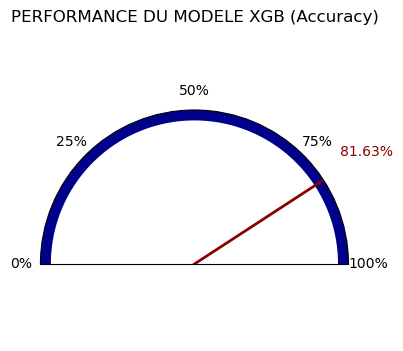

In [25]:
def draw_gauge(accuracy_score):
    # Normaliser le score entre 0 et 1
    normalized_score = accuracy_score

    # Créer un axe polar
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"polar": True})

    # Dessiner l'arc de la jauge (demi-cercle supérieur)
    arc = np.linspace(0, np.pi, 100)
    r = np.full(100, 0.6)
    ax.plot(arc, r, color="darkblue", linewidth=15)

    # Calculer l'angle pour l'aiguille
    theta = np.pi * (normalized_score)
    ax.plot([theta, theta], [0, 0.6], color='darkred', linewidth=2)

    # Marquer le score sur l'aiguille
    ax.text(theta , 0.8, f"{accuracy_score * 100:.2f}%", color='darkred', ha="center", va="center")

    # Configurer les angles et étiquettes en pourcentage
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians([0, 45, 90, 135, 180]))
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])

    # Supprimer les rayons et les étiquettes radiales
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Supprimer les lignes radiales
    ax.grid(False)

    # Réduire la vue au demi-cercle
    ax.set_ylim([0, 0.6])
    ax.set_xlim([0, np.pi])

    ax.set_title("PERFORMANCE DU MODELE XGB (Accuracy)", va="bottom")

    plt.show()

    fig.savefig("Divers/jauge_xgb.png")

accuracy_value = accuracy
draw_gauge(accuracy_value)

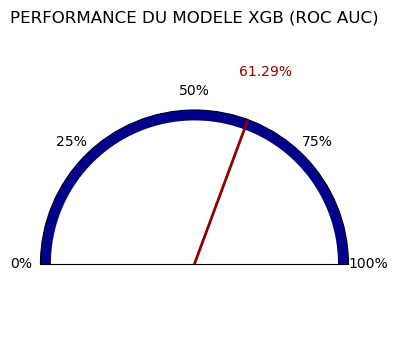

In [26]:
def draw_gauge(accuracy_score):
    if not np.isscalar(accuracy_score):
        raise ValueError("La valeur fournie à 'draw_gauge' doit être un scalaire.")

    # Normaliser le score entre 0 et 1
    normalized_score = accuracy_score

    # Créer un axe polar
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"polar": True})

    # Dessiner l'arc de la jauge (demi-cercle supérieur)
    arc = np.linspace(0, np.pi, 100)
    r = np.full(100, 0.6)
    ax.plot(arc, r, color="darkblue", linewidth=15)

    # Calculer l'angle pour l'aiguille
    theta = np.pi * (normalized_score)
    ax.plot([theta, theta], [0, 0.6], color='darkred', linewidth=2)

    # Marquer le score sur l'aiguille
    ax.text(theta , 0.8, f"{accuracy_score * 100:.2f}%", color='darkred', ha="center", va="center")

    # Configurer les angles et étiquettes en pourcentage
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians([0, 45, 90, 135, 180]))
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])

    # Supprimer les rayons et les étiquettes radiales
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Supprimer les lignes radiales
    ax.grid(False)

    # Réduire la vue au demi-cercle
    ax.set_ylim([0, 0.6])
    ax.set_xlim([0, np.pi])

    ax.set_title("PERFORMANCE DU MODELE XGB (ROC AUC)", va="bottom")

    plt.show()

    fig.savefig("Divers/jauge_xgb_auc.png")

accuracy_value = roc_auc
draw_gauge(accuracy_value)

In [27]:
y_pred_proba = grid_search_xgb_opti.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

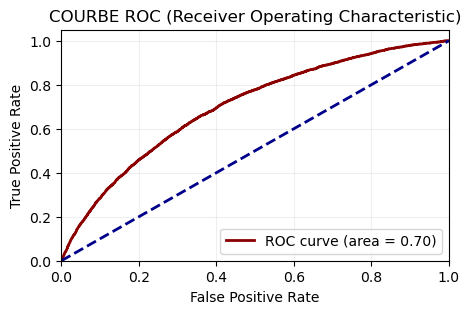

In [28]:
# Créer la figure et l'axe
fig, ax = plt.subplots(figsize=(5, 3))

# Tracer la courbe ROC sur l'axe
ax.plot(fpr, tpr, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')  # ligne diagonale pour un modèle aléatoire
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('COURBE ROC (Receiver Operating Characteristic)')
ax.legend(loc="lower right")
ax.grid(alpha=0.2)
plt.show()

# Sauvegarder la figure
fig.savefig("Divers/courbe_roc.png")

In [29]:
mlflow.end_run()

In [30]:
# Enregistrer le modèle et les variables associées avec joblib
file_path = "../projet7_git/xgb_model.joblib"
data_to_save = {
    "model": grid_search_xgb_opti,
    "roc_auc": roc_auc,
    "confusion_matrix": cmxgb
}

dump(data_to_save, file_path)

print("Modèle XGBoost et variables enregistrés avec succès.")

Modèle XGBoost et variables enregistrés avec succès.


In [31]:
sample_data = {
    "EXT_SOURCE_3": 0.15,  
    "EXT_SOURCE_2": 0.27,
    "NAME_INCOME_TYPE_Working": 1,  
    "NAME_EDUCATION_TYPE_Secondary / secondary special": 1, 
    "NAME_EDUCATION_TYPE_Higher education": 0,
    "OCCUPATION_TYPE_Core staff": 0,
    "FLAG_DOCUMENT_3": 1,  
    "AMT_REQ_CREDIT_BUREAU_HOUR": 0.0, 
    "CODE_GENDER": 0, 
    "PAYMENT_RATE": 0.065,  
}

In [32]:
# Création du DataFrame avec les données d'exemple
sample_df = pd.DataFrame([sample_data])

# Utilisation du modèle pour faire des prédictions
prediction = grid_search_xgb_opti.predict(sample_df)
print(prediction)

ValueError: feature_names mismatch: ['Source_3', 'Source_2', 'Travail', 'Lycée', 'Etudes Sup', 'Cadre', 'Indic_doc 3', 'Nb demandes/h', 'Sexe', 'Tx pay.'] ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_EDUCATION_TYPE_Higher education', 'OCCUPATION_TYPE_Core staff', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'CODE_GENDER', 'PAYMENT_RATE']
expected Source_2, Sexe, Cadre, Etudes Sup, Indic_doc 3, Source_3, Tx pay., Nb demandes/h, Travail, Lycée in input data
training data did not have the following fields: OCCUPATION_TYPE_Core staff, AMT_REQ_CREDIT_BUREAU_HOUR, NAME_INCOME_TYPE_Working, EXT_SOURCE_3, CODE_GENDER, EXT_SOURCE_2, FLAG_DOCUMENT_3, NAME_EDUCATION_TYPE_Secondary / secondary special, PAYMENT_RATE, NAME_EDUCATION_TYPE_Higher education

In [ ]:
# Création du DataFrame avec les données d'exemple
sample_df = pd.DataFrame([sample_data])

# Utilisation du modèle pour obtenir les probabilités de classe
probabilities = grid_search_xgb_opti.predict_proba(sample_df)

# Probabilité de la classe 1 (assumant que 1 est la classe positive)
probability_of_class_1 = probabilities[0][1]

# Affichage de la probabilité de la classe 1 en pourcentage
print(f"Probabilité de la classe 1 : {probability_of_class_1 * 100:.2f}%")

In [ ]:
# Faite un tableau pour trouver le seuil adapté
y_probs = grid_search_xgb_opti.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 50)  # test 50 seuils entre 0 et 1
results = []

for threshold in thresholds:
    y_pred = [1 if prob >= threshold else 0 for prob in y_probs]
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1,
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn
    })

# Transformez les résultats en un DataFrame pour une analyse facile
results_df = pd.DataFrame(results)

In [ ]:
results_df

In [ ]:
results_df.loc[35]

Le seuil sera donc à 70%.

In [ ]:
# Obtenez les probabilités de la classe positive
probabilities = grid_search_xgb_opti.predict_proba(sample_df)[:, 1]

In [ ]:
def draw_client(accuracy_score):
    if not np.isscalar(accuracy_score):
        raise ValueError("La valeur fournie à 'draw_gauge' doit être un scalaire.")

    # Normaliser le score entre 0 et 1
    normalized_score = accuracy_score

    # Créer un axe polar
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"polar": True})

    # Dessiner l'arc de la jauge pour la plage de 0 à 70% (en rouge)
    arc_red = np.linspace(0, 0.7 * np.pi, 100)
    r_red = np.full(100, 0.6)
    ax.plot(arc_red, r_red, color="red", linewidth=15)

    # Dessiner l'arc de la jauge pour la plage de 70 à 100% (en bleu)
    arc_blue = np.linspace(0.7 * np.pi, np.pi, 100)
    r_blue = np.full(100, 0.6)
    ax.plot(arc_blue, r_blue, color="darkblue", linewidth=15)

    # Calculer l'angle pour l'aiguille
    theta = np.pi * (normalized_score)
    needle, = ax.plot([theta, theta], [0, 0.6], color='darkred', linewidth=2)

    # Configurer les angles et étiquettes en pourcentage
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians([0, 45, 90, 126, 135, 180]))
    ax.set_xticklabels(["0%", "25%", "50%","70%", "75%", "100%"])

    # Supprimer les rayons et les étiquettes radiales
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Supprimer les lignes radiales
    ax.grid(False)

    # Réduire la vue au demi-cercle
    ax.set_ylim([0, 0.6])
    ax.set_xlim([0, np.pi])

    ax.set_title("EVALUATION DU CLIENT", va="bottom")

    # Ajouter le score en tant que légende
    ax.legend([needle], [f'Score = {accuracy_score * 100:.2f}%'])

    plt.show()

In [ ]:
sample_probability = probabilities[0]
draw_client(sample_probability)

In [ ]:
print(probabilities)

LIME/SHAP

In [ ]:
sample_data = {
    "EXT_SOURCE_3": 0.15,  
    "EXT_SOURCE_2": 0.27,
    "NAME_INCOME_TYPE_Working": 1,  
    "NAME_EDUCATION_TYPE_Secondary / secondary special": 1, 
    "NAME_EDUCATION_TYPE_Higher education": 0,
    "OCCUPATION_TYPE_Core staff": 0,
    "FLAG_DOCUMENT_3": 1,  
    "AMT_REQ_CREDIT_BUREAU_HOUR": 0.0, 
    "CODE_GENDER": 0, 
    "PAYMENT_RATE": 0.065,  
}

In [ ]:
# Récupération du meilleur estimateur XGBoost du GridSearch
best_xgb_model = grid_search_xgb_opti.best_estimator_['xgb']

In [ ]:
# 1. Initialiser l'explainer
explainer = LimeTabularExplainer(training_data = X_train.values,
                                 feature_names = X_train.columns,
                                 class_names = ["Not Default", "Default"],
                                 mode = 'classification')

# 2. Expliquer la prédiction de `sample_data`
exp = explainer.explain_instance(np.array(pd.DataFrame([sample_data]).iloc[0]), best_xgb_model.predict_proba, num_features=10)

# 3. Visualiser l'explication
exp.show_in_notebook()


In [ ]:
# Charger le modèle et les variables associées
file_path = "../projet7_git/xgb_model.joblib"
loaded_data = load(file_path)
loaded_model = loaded_data["model"]

In [ ]:
# Création d'un DataFrame pour la prédiction
sample_df = pd.DataFrame([sample_data])

# Effectuer la prédiction
sample_prediction = loaded_model.predict(sample_df)
print(f"La prédiction pour sample_data est: {sample_prediction[0]}")

# Calcul de la probabilité
sample_proba = loaded_model.predict_proba(sample_df)
print(f"La probabilité que sample_data appartienne à la classe 1 est: {sample_proba[0][1]:.2f}")

In [ ]:
loaded_data = load('xgb_model.joblib')
print(type(loaded_data))


In [ ]:
model = loaded_data['model']

best_params = None

# Vérifier si 'best_params_' est un attribut du modèle
if hasattr(model, 'best_params_'):
    best_params = model.best_params_

print(best_params)

In [ ]:
# Étape 0 : Charger le modèle et obtenir le meilleur estimateur XGB
model = loaded_data['model']

if not hasattr(model, 'best_estimator_'):
    raise ValueError("Le modèle chargé ne semble pas être un résultat de GridSearchCV.")

xgb_model = model.best_estimator_['xgb']

# Étape 1 : Initialiser le Explainer avec le modèle XGB
explainer = shap.Explainer(xgb_model)

# Étape 2 : Obtenir les valeurs SHAP pour sample_data
shap_values = explainer.shap_values(pd.DataFrame([sample_data]))

# Étape 3 : Visualiser l'explication
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], pd.DataFrame([sample_data]))


In [ ]:
df.dtypes

In [ ]:
import pandas as pd
test_final = pd.read_csv('test_data.csv', index_col="SK_ID_CURR")
test_final.tail(10)

In [ ]:
import pandas as pd
test_final = pd.read_csv('complet_data.csv', index_col = "SK_ID_CURR")
test_final.head(5)